## Imports

In [2]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import random

In [4]:
data_path = '/home/jupyter/SalaryPrediction/Data/'

train_path = data_path + 'train_clean_with_text.csv'
val_path = data_path + 'val_clean_with_text.csv'
test_path = data_path + 'test_clean_with_text.csv'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Fixing seeds

In [6]:
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed) #const hash for python
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Data reading

In [8]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

In [9]:
df_train.head()

,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,The Litigation team at this well regarded Comm...,london,full_time,permanent,Other,Legal Jobs,100000
1,Endoscopy Staff Nurse NHS London **** **** H...,thecity,full_time,permanent,ukstaffsearch,Other/General Jobs,29284
2,An experienced Operations Director is required...,letchworthgardencity,full_time,permanent,ukstaffsearch,Consultancy Jobs,97500
3,The Danny Sullivan Group is looking for a Site...,dudley,full_time,permanent,cvbrowser,Engineering Jobs,34320
4,A promising opportunity for an exceptional man...,kent,full_time,permanent,Other,Accounting & Finance Jobs,37500


## Data cleaning

#### Spliting dataset

In [10]:
X_train = df_train.drop('SalaryNormalized', axis=1)
y_train = df_train['SalaryNormalized']

X_val = df_val.drop('SalaryNormalized', axis=1)
y_val = df_val['SalaryNormalized']

X_test = df_test.drop('SalaryNormalized', axis=1)
y_test = df_test['SalaryNormalized']

In [11]:
X_train.shape

(172683, 6)

#### Log transformation

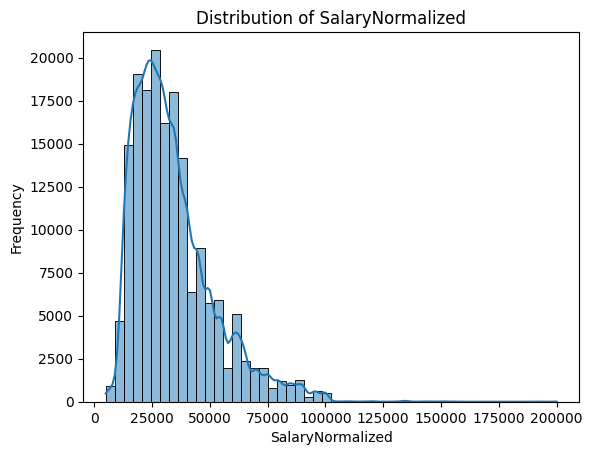

In [12]:
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribution of SalaryNormalized')
plt.xlabel('SalaryNormalized')
plt.ylabel('Frequency')
plt.show()

In [13]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

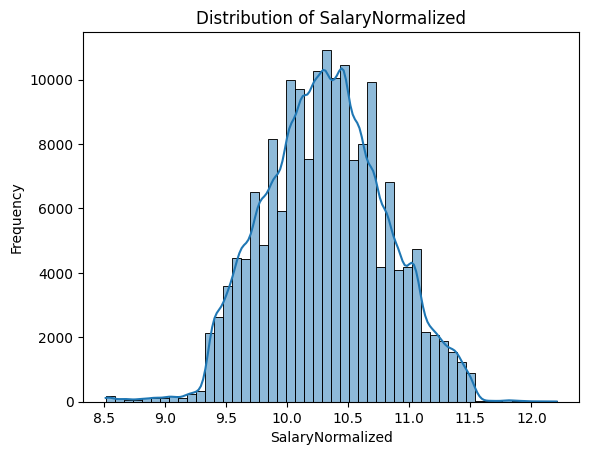

In [14]:
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribution of SalaryNormalized')
plt.xlabel('SalaryNormalized')
plt.ylabel('Frequency')
plt.show()

#### Tokenization

Original Description: 
The Litigation team at this well regarded Commercial firm has an opportunity for an intelligent and personable Senior Associate (5 years’ PQE) to handle an interesting spread of commercial and financial litigation. The successful candidate will ideally have experience in financial/banking litigation as well as general commercial litigation, be accustomed to handling their own cases and managing a team. He or she will also be adept at maintaining and developing client relations. The candidate will also have experience of working with clients and lawyers in jurisdictions outside the UK. You will currently be working as a Commercial Litigator at a firm well regarded for the work it does in Commercial Litigation. They will also consider barristers who have undertaken predominantly Commercial Litigation matters and currently hold tenancy with a strong London set.

Tokenized Description: 
['Litigation', 'team', 'well', 'regarded', 'Commercial', 'firm', 'opportunity', '

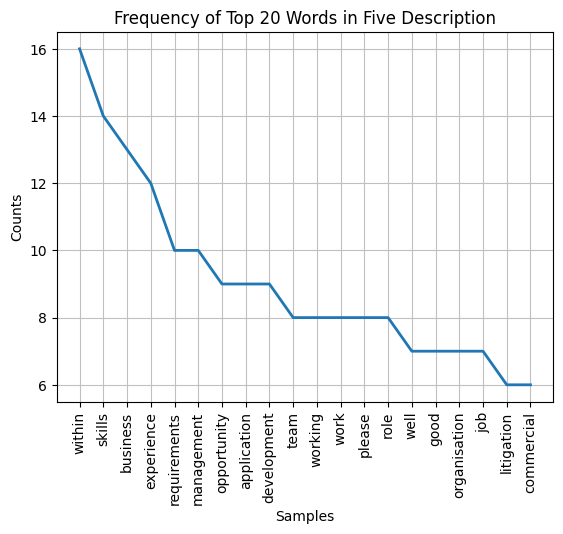

In [15]:
descriptions_tokens = []
stop_words = set(stopwords.words("english"))

X_train_copy = X_train.copy()[:10]

for description in X_train_copy['FullDescription']:
    description = description.translate(str.maketrans('', '', string.punctuation))
    word_tokens = word_tokenize(description)
    filtered = [word for word in word_tokens if word.lower() not in stop_words]
    descriptions_tokens.append(filtered)

X_train_copy['Token_Description'] = descriptions_tokens
print('Original Description: \n' + X_train_copy.loc[0, 'FullDescription'])
print('\nTokenized Description: ')
print(X_train_copy.loc[0, 'Token_Description'])

fdist = FreqDist()

for token_des in X_train_copy['Token_Description']:
    for word in token_des:
        fdist[word.lower()] += 1

print('\nFive Most Common Words and Their Frequencies:')
print(fdist.most_common(5))
fdist.plot(20, title = 'Frequency of Top 20 Words in Five Description')
plt.show()

In [16]:
stop_words = set(stopwords.words("english"))

#'The white flower.'
def tokenize_description(text):
    text = text.translate(str.maketrans('', '', string.punctuation)) #'The white flower'
    tokens = word_tokenize(text) #['The', 'white', 'flower']
    filtered = [word.lower() for word in tokens if word.lower() not in stop_words] #['white', 'flower']
    return filtered

def build_vocab(token_lists, min_freq=5):
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    freq = {}

    for tokens in token_lists:
        for word in tokens:
            freq[word] = freq.get(word, 0) + 1
            if freq[word] == min_freq:
                word2idx[word] = len(word2idx)

    return word2idx #word2idx = {'<PAD>':0, '<UNK>':1, 'white':2, 'flower':3}


def tokens_to_indices(tokens, word2idx):
    return [word2idx.get(word, word2idx['<UNK>']) for word in tokens]
#tokens=['white', 'flower', 'dog']
#word2idx = {'<PAD>':0, '<UNK>':1, 'white':2, 'flower':3}
#output = [2, 3, 1]

In [17]:
X_train['Token_Description'] = X_train['FullDescription'].apply(tokenize_description)
X_val['Token_Description'] = X_val['FullDescription'].apply(tokenize_description)
X_test['Token_Description'] = X_test['FullDescription'].apply(tokenize_description)

word2idx = build_vocab(X_train['Token_Description'])

train_seqs = [torch.tensor(tokens_to_indices(t, word2idx)) for t in X_train['Token_Description']]
val_seqs = [torch.tensor(tokens_to_indices(t, word2idx)) for t in X_val['Token_Description']]
test_seqs = [torch.tensor(tokens_to_indices(t, word2idx)) for t in X_test['Token_Description']]

#Before: [[2,1], [5], [2, 3, 4]]
train_seqs = pad_sequence(train_seqs, batch_first=True)
val_seqs = pad_sequence(val_seqs, batch_first=True)
test_seqs = pad_sequence(test_seqs, batch_first=True)
#After: [[2, 1, 0], [5, 0, 0], [2, 3, 4]]

vocab_size = len(word2idx)

#### Label encoding

In [18]:
encoders = {}
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()
X_test_encoded = X_test.copy()

for col in X_train.columns:
    if col != 'FullDescription' and col != 'Token_Description':
        le = LabelEncoder()
        X_train_encoded[col] = le.fit_transform(X_train[col])
        X_val_encoded[col] = le.transform(X_val[col])
        X_test_encoded[col] = le.transform(X_test[col])
        encoders[col] = le

In [19]:
print(X_train.shape, X_val.shape, X_test.shape)

(172683, 7) (35369, 7) (36716, 7)


In [20]:
X_train_encoded.drop(['FullDescription'], axis=1, inplace=True)
X_val_encoded.drop(['FullDescription'], axis=1, inplace=True)
X_test_encoded.drop(['FullDescription'], axis=1, inplace=True)

#### Embedding

In [21]:
embedding_sizes = []

for col in X_train_encoded.columns:
    if col == "Token_Description":
        continue
    num_categories = len(encoders[col].classes_) #num of unique values
    emb_dim = min(5, (num_categories + 1) // 4)
    embedding_sizes.append((num_categories, emb_dim))

#### Architecture

In [22]:
class SalaryDataset(Dataset):
    def __init__(self, X, y, word2idx):
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
        self.cat_data = torch.tensor(X.drop(columns=["Token_Description"]).values, dtype=torch.long)
        self.text_data = X["Token_Description"].tolist()
        self.word2idx = word2idx

    def __len__(self):
        return len(self.cat_data)

    def __getitem__(self, idx):
        text_indices = tokens_to_indices(self.text_data[idx], self.word2idx)
        return self.cat_data[idx], torch.tensor(text_indices, dtype=torch.long), self.y[idx]

In [32]:
class SalaryModel(nn.Module):
    def __init__(self, embedding_sizes, vocab_size, text_emb_dim=50):
        super().__init__()
        # [(2,3), (10, 2)]
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim) # nn.Embedding(2, 3)
            for num_categories, emb_dim in embedding_sizes
        ])

        cat_emb_dim = sum([emb_dim for _, emb_dim in embedding_sizes])

        self.text_embedding = nn.Embedding(vocab_size, text_emb_dim, padding_idx=0)
        total_input_dim = cat_emb_dim + text_emb_dim

        #self.bn01 = nn.BatchNorm1d(total_input_dim)
        self.fc1 = nn.Linear(total_input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.ln1 = nn.LayerNorm(32)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.ln2 = nn.LayerNorm(16)
        self.dropout2 = nn.Dropout(0.05)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, cat_input, text_input):
        embedded_cat = [emb(cat_input[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_out = torch.cat(embedded_cat, dim=1)

        text_emb = self.text_embedding(text_input)
        text_out = text_emb.mean(dim=1)

        x = torch.cat([cat_out, text_out], dim=1)

        #x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout1(x)
        #x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout2(x)

        return self.fc3(x)


## Training the model

In [24]:
#__get_item__: (cat_tensor, text_tensor, label)
#batch = [(tensor([1, 2]), tensor([3, 4, 5]), tensor([50000.])),
#         (tensor([0, 1]), tensor([7, 8]), tensor([60000.]))]


def collate_fn(batch):
    cat_feats, text_feats, labels = zip(*batch) #cat_feats = (tensor([1, 2]), tensor([0, 1]))
                                                #text_feats = (tensor([3, 4, 5]), tensor([7, 8]))
                                                #labels = (tensor([50000.]), tensor([60000.]))

    cat_feats = torch.stack(cat_feats) #cat_feats = (tensor([1,2], [0,1]))
    text_feats = pad_sequence(text_feats, batch_first=True, padding_value=0) #text_feats =(tensor([3,4,5], [7,8,0]))
    labels = torch.stack(labels) #labels = tensor([50000.], [60000.])

    return cat_feats, text_feats, labels

In [33]:
train_dataset = SalaryDataset(X_train_encoded, y_train, word2idx)
val_dataset = SalaryDataset(X_val_encoded, y_val, word2idx)
test_dataset = SalaryDataset(X_test_encoded, y_test, word2idx)

g = torch.Generator()
g.manual_seed(42)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=g, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=g, collate_fn=collate_fn)

In [34]:
set_seed(42)
model = SalaryModel(embedding_sizes, vocab_size=vocab_size, text_emb_dim=5)
model = model.to(device)
loss_fn = torch.nn.SmoothL1Loss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)


def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count_trainable_params(model)}")


Number of trainable parameters: 247189


In [35]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    num_batches = 0
    batch_losses = []

    for i, (cat_inputs, text_inputs, labels) in enumerate(train_loader):
        # Move data to the same device as the model
        cat_inputs = cat_inputs.to(device)
        text_inputs = text_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(cat_inputs, text_inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if i % 500 == 499:
            last_loss = running_loss / 500
            batch_losses.append(last_loss)
            print(f'  batch {i+1} loss: {last_loss:.4f}')
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    return last_loss, batch_losses

## Evaluation the model

In [42]:
def changing_to_original_metric(y_pred, y_true):
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")
    return y_pred, y_true

In [37]:
patience = 5
best_vloss = float('inf')
epochs_without_improvement = 0
model_save_path = 'best_model.pth'

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

epoch_number = 0
EPOCHS = 100

train_losses = []
val_losses = []
train_batch_losses = []
val_batch_losses = []


for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    model.train(True)
    avg_train_loss, batch_train_losses = train_one_epoch(epoch_number, writer)
    train_losses.append(avg_train_loss)
    train_batch_losses.extend(batch_train_losses)

    model.eval()
    running_vloss = 0.0
    r_vloss = 0.0
    batch_val_losses = []
    all_val_outputs = []
    all_val_labels = []

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            cat_inputs, text_inputs, vlabels = vdata

            cat_inputs = cat_inputs.to(device)
            text_inputs = text_inputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = model(cat_inputs, text_inputs)
            vloss = loss_fn(voutputs, vlabels)

            loss_value = vloss.item()
            running_vloss += loss_value
            r_vloss += loss_value
            if i % 500 == 499:
                last_loss = r_vloss / 500
                batch_val_losses.append(last_loss)
                r_vloss = 0.0

            all_val_outputs.extend(voutputs.cpu().numpy())
            all_val_labels.extend(vlabels.cpu().numpy())

    avg_vloss = running_vloss / (i + 1)
    val_losses.append(avg_vloss)
    val_batch_losses.extend(batch_val_losses)
    scheduler.step(avg_vloss)


    mse_val = mean_squared_error(all_val_labels, all_val_outputs)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(all_val_labels, all_val_outputs)

    print(f'LOSS train: {avg_train_loss:.4f}, valid: {avg_vloss:.4f}')
    print("--------------------------------")
    print(f"MSE: {mse_val:.4f}")
    print(f"RMSE: {rmse_val:.4f}")
    print(f"R²: {r2_val:.4f}")
    print("--------------------------------")
    print("Original scale")
    all_val_outputs_original, all_val_labels_original = changing_to_original_metric(all_val_outputs, all_val_labels)
    mse_val_original = mean_squared_error(all_val_labels_original, all_val_outputs_original)
    rmse_val_original = np.sqrt(mse_val_original)
    r2_val_original = r2_score(all_val_labels_original, all_val_outputs_original)
    print("\n")

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_train_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), model_save_path)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch_number + 1}')
        break

    epoch_number += 1


EPOCH 1:
  batch 500 loss: 4.1904
  batch 1000 loss: 0.4252
  batch 1500 loss: 0.3900
  batch 2000 loss: 0.3650
  batch 2500 loss: 0.3551
LOSS train: 0.3551, valid: 0.0823
--------------------------------
MSE: 0.1659
RMSE: 0.4073
R²: 0.3112
--------------------------------
Original scale
MSE: 268506848.0000
RMSE: 16386.1786
R²: 0.1379


EPOCH 2:
  batch 500 loss: 0.3369
  batch 1000 loss: 0.3299
  batch 1500 loss: 0.3185
  batch 2000 loss: 0.2862
  batch 2500 loss: 0.2581
LOSS train: 0.2581, valid: 0.0550
--------------------------------
MSE: 0.1107
RMSE: 0.3327
R²: 0.5403
--------------------------------
Original scale
MSE: 181152944.0000
RMSE: 13459.3070
R²: 0.4184


EPOCH 3:
  batch 500 loss: 0.2504
  batch 1000 loss: 0.2400
  batch 1500 loss: 0.2368
  batch 2000 loss: 0.2257
  batch 2500 loss: 0.2199
LOSS train: 0.2199, valid: 0.0494
--------------------------------
MSE: 0.0995
RMSE: 0.3155
R²: 0.5868
--------------------------------
Original scale
MSE: 164102656.0000
RMSE: 12810.2

### Improvements

LOSS train: 0.0367, valid: 0.0395
MSE: 0.0796
RMSE: 0.2822
R²: 0.6695
Original scale
MSE: 122744712.0000
RMSE: 11079.0213
R²: 0.6059

Dropout: 0.1 after first

LOSS train: 0.0289, valid: 0.0321
MSE: 0.0648
RMSE: 0.2546
R²: 0.7309
Original scale
MSE: 102198888.0000
RMSE: 10109.3466
R²: 0.6719

Dropout: 0.1 and 0.1

LOSS train: 0.0351, valid: 0.0317
MSE: 0.0641
RMSE: 0.2532
R²: 0.7339
Original scale
MSE: 101942328.0000
RMSE: 10096.6493
R²: 0.6727

Dropout: 0.1 and 0.05

LOSS train: 0.0346, valid: 0.0313
MSE: 0.0631
RMSE: 0.2512
R²: 0.7380
Original scale
MSE: 101177544.0000
RMSE: 10058.7049
R²: 0.6752

Dropout 0.1 and 0.05, patience in ES: 5

LOSS train: 0.0317, valid: 0.0307
MSE: 0.0620
RMSE: 0.2489
R²: 0.7427
Original scale
MSE: 99788424.0000
RMSE: 9989.4156
R²: 0.6796

Drpout 0.1 and 0.05, patience in ES: 5, patience in scheduler: 1

LOSS train: 0.0315, valid: 0.0307
MSE: 0.0620
RMSE: 0.2489
R²: 0.7428
Original scale
MSE: 99773496.0000
RMSE: 9988.6684
R²: 0.6797

Changing to LayerNorm:

LOSS train: 0.0230, valid: 0.0297
MSE: 0.0600
RMSE: 0.2450
R²: 0.7509
Original scale
MSE: 91618752.0000
RMSE: 9571.7685
R²: 0.7058

#### Before

#### After

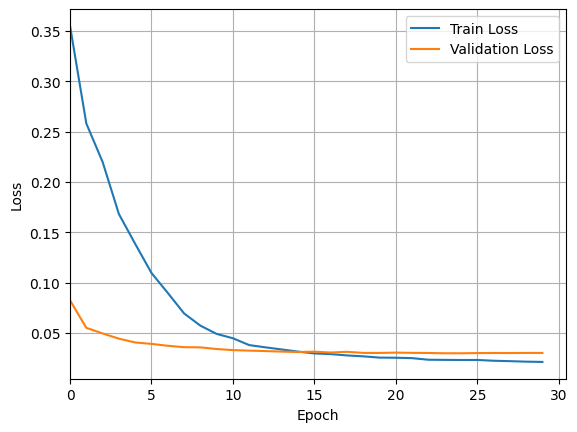

In [38]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0)
plt.legend()
plt.grid(True)
plt.show()


## Evaluation on the test set

In [39]:
model = SalaryModel(embedding_sizes, vocab_size=vocab_size, text_emb_dim=5)
model.load_state_dict(torch.load(model_save_path))
model.eval()

SalaryModel(
  (embeddings): ModuleList(
    (0): Embedding(1000, 5)
    (1-2): 2 x Embedding(3, 1)
    (3): Embedding(1001, 5)
    (4): Embedding(29, 5)
  )
  (text_embedding): Embedding(47112, 5, padding_idx=0)
  (fc1): Linear(in_features=22, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.05, inplace=False)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [43]:
running_test_loss = 0.0


all_outputs = []
all_labels = []

with torch.no_grad():
    for i, (cat_inputs, text_inputs, test_labels) in enumerate(test_loader):
        test_outputs = model(cat_inputs, text_inputs)
        test_loss = loss_fn(test_outputs, test_labels)
        running_test_loss += test_loss.item()

        all_outputs.extend(test_outputs.numpy())
        all_labels.extend(test_labels.numpy())

avg_test_loss = running_test_loss / (i + 1)
print(f"Test Loss: {avg_test_loss:.4f}")

mse = mean_squared_error(all_labels, all_outputs)
rmse = np.sqrt(mse)
mae= mean_absolute_error(all_labels, all_outputs)
r2 = r2_score(all_labels, all_outputs)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Test Loss: 0.0296
MSE: 0.0602
RMSE: 0.2454
MAE: 0.1759
R²: 0.7506


In [46]:
print(changing_to_original_metric(all_outputs, all_labels))

MSE: 93263216.0000
RMSE: 9657.2882
MAE: 6140.5034
R²: 0.7011
(array([[30442.607],
       [26054.348],
       [27566.975],
       ...,
       [37089.008],
       [38691.434],
       [28211.393]], dtype=float32), array([[23500.002],
       [23040.002],
       [34850.016],
       ...,
       [39999.996],
       [42500.   ],
       [31000.006]], dtype=float32))
